In [64]:
# vivarium / pandas combination here is giving a ton of future warnings
# try to suppress them...

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# this works if you execute it _before_ importing vivarium

In [65]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [66]:
path = Path('/ihme/homes/abie/projects/2023/'
            'vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/abie/projects/2023/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [67]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-06-17 16:23:23.422 | INFO     | simulation_2-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/washington.hdf.
2023-06-17 16:23:23.424 | INFO     | simulation_2-artifact_manager:67 - Artifact base filter terms are ['draw == 0'].
2023-06-17 16:23:23.426 | INFO     | simulation_2-artifact_manager:68 - Artifact additional filter terms are None.


In [68]:
pop0 = sim.get_population()
pop0.head()

,tracked,entrance_time,location,alive,sex,exit_time,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,polypill,lifestyle,ldlc_medication_adherence,ldlc_medication,sbp_medication,ldlc_multiplier,sbp_medication_adherence,last_fpg_test_date,visit_type,scheduled_date
0,True,2020-12-04,Washington,alive,Female,NaT,47.372524,not_dead,0.0,0.0,...,cat2,NaT,cat3,no_treatment,no_treatment,1.0,cat3,NaT,none,NaT
1,True,2020-12-04,Washington,alive,Male,NaT,41.533610,not_dead,0.0,0.0,...,cat2,NaT,cat3,no_treatment,no_treatment,1.0,cat3,NaT,none,NaT
2,True,2020-12-04,Washington,alive,Female,NaT,53.154618,not_dead,0.0,0.0,...,cat2,NaT,cat3,no_treatment,two_drug_half_dose_efficacy,1.0,cat3,NaT,none,2021-03-18 20:59:59.649561600
3,True,2020-12-04,Washington,alive,Male,NaT,30.471181,not_dead,0.0,0.0,...,cat2,NaT,cat3,no_treatment,no_treatment,1.0,cat3,NaT,none,NaT
4,True,2020-12-04,Washington,alive,Female,NaT,19.548380,not_dead,0.0,0.0,...,cat2,NaT,cat1,no_treatment,no_treatment,1.0,cat3,NaT,none,NaT


In [69]:
pop0.columns

Index(['tracked', 'entrance_time', 'location', 'alive', 'sex', 'exit_time',
       'age', 'cause_of_death', 'years_of_life_lost',
       'years_lived_with_disability',
       'previous_ischemic_heart_disease_and_heart_failure',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'susceptible_to_ischemic_stroke_event_time',
       'su

In [70]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate.paf',
 'disability_weight',
 'sbp_medication_adherence.propensity',
 'sbp_medication_adherence.exposure',
 'risk_factor.sbp_medication_adherence.exposure_parameters',
 'ldlc_medication_adherence.propensity',
 'ldlc_medication_adherence.exposure',
 'risk_factor.ldlc_medication_adherence.exposure_parameters',
 'outreach.propensity',
 'outreach.exposure',
 'risk_factor.outreach.exposure_parameters',
 'risk_factor.outreach.exposure_parameters.paf',
 'polypill.propensity',
 'polypill.exposure',
 'risk_factor.polypill.exposure_parameters',
 'risk_factor.polypill.exposure_parameters.paf',
 'lifestyle.propensity',
 'lifestyle.exposure',
 'risk_factor.lifestyle.exposure_parameters',
 'risk_factor.lifestyle.exposure_parameters.paf',
 'high_ldl_cholesterol.exposure',
 'acute_myocardial_infarction.incidence_rate',
 'acute_myocardia

In [71]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('high_ldl_prop'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('high_sbp_prop'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('high_bmi_prop'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('high_fpg_prop'),
                   sim.get_value('heart_failure_from_ischemic_heart_disease.incidence_rate')(pop0.index).rename('hf_ihd'),
                   sim.get_value('heart_failure_residual.incidence_rate')(pop0.index).rename('hf_resid'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke'),
                   sim.get_value('post_myocardial_infarction_to_acute_myocardial_infarction.transition_rate')(pop0.index).rename('post_stroke'),
                  ], axis=1)
data1.head()

,tracked,entrance_time,location,alive,sex,exit_time,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_fpg,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke
0,True,2020-12-04,Washington,alive,Female,NaT,47.372524,not_dead,0.0,0.0,...,7.739470,0.646760,0.318659,0.018413,0.869012,9.791059e-06,0.000036,1.376987e-05,0.000014,1.376987e-05
1,True,2020-12-04,Washington,alive,Male,NaT,41.533610,not_dead,0.0,0.0,...,7.834330,0.973430,0.127935,0.379563,0.872558,8.593075e-06,0.000029,9.670926e-05,0.000009,9.670926e-05
2,True,2020-12-04,Washington,alive,Female,NaT,53.154618,not_dead,0.0,0.0,...,3.203468,0.953247,0.382591,0.235442,0.148154,2.014274e-05,0.000050,3.904679e-05,0.000035,3.904679e-05
3,True,2020-12-04,Washington,alive,Male,NaT,30.471181,not_dead,0.0,0.0,...,3.741236,0.448085,0.321583,0.941788,0.025945,9.212785e-06,0.000052,3.658443e-05,0.000007,3.658443e-05
4,True,2020-12-04,Washington,alive,Female,NaT,19.548380,not_dead,0.0,0.0,...,1.000000,0.034469,0.583055,0.919584,0.957947,6.775691e-07,0.000017,2.121917e-07,0.000004,2.121917e-07


In [72]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

In [73]:
data1.head()

,tracked,entrance_time,location,alive,sex,exit_time,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke,age_start
0,True,2020-12-04,Washington,alive,Female,NaT,47.372524,not_dead,0.0,0.0,...,0.646760,0.318659,0.018413,0.869012,0.000010,0.000036,0.000014,0.000014,0.000014,45.0
1,True,2020-12-04,Washington,alive,Male,NaT,41.533610,not_dead,0.0,0.0,...,0.973430,0.127935,0.379563,0.872558,0.000009,0.000029,0.000097,0.000009,0.000097,40.0
2,True,2020-12-04,Washington,alive,Female,NaT,53.154618,not_dead,0.0,0.0,...,0.953247,0.382591,0.235442,0.148154,0.000020,0.000050,0.000039,0.000035,0.000039,50.0
3,True,2020-12-04,Washington,alive,Male,NaT,30.471181,not_dead,0.0,0.0,...,0.448085,0.321583,0.941788,0.025945,0.000009,0.000052,0.000037,0.000007,0.000037,30.0
6,True,2020-12-04,Washington,alive,Male,NaT,33.670699,not_dead,0.0,0.0,...,0.601506,0.500085,0.818541,0.764860,0.000010,0.000055,0.000062,0.000007,0.000062,30.0


In [74]:
data1_small = data1.loc[(data1.sex=='Male') & (data1.age_start == 85) | (data1.age_start == 65)]
data1_small

,tracked,entrance_time,location,alive,sex,exit_time,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke,age_start
9,True,2020-12-04,Washington,alive,Male,NaT,68.923092,not_dead,0.0,0.0,...,0.397425,0.436258,0.105124,0.416225,0.000528,0.000402,0.000213,0.000039,0.000213,65.0
13,True,2020-12-04,Washington,alive,Female,NaT,68.052824,not_dead,0.0,0.0,...,0.193485,0.426752,0.836926,0.117485,0.000323,0.000400,0.000141,0.000056,0.000141,65.0
17,True,2020-12-04,Washington,alive,Male,NaT,85.874770,not_dead,0.0,0.0,...,0.905945,0.190968,0.538555,0.436118,0.004768,0.003721,0.000513,0.000352,0.000513,85.0
19,True,2020-12-04,Washington,alive,Female,NaT,69.239203,not_dead,0.0,0.0,...,0.328992,0.076748,0.481128,0.307703,0.000219,0.000272,0.000067,0.000025,0.000067,65.0
44,True,2020-12-04,Washington,alive,Male,NaT,88.342687,not_dead,0.0,0.0,...,0.786564,0.294314,0.775929,0.842002,0.005214,0.004069,0.000793,0.000432,0.000793,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49910,True,2020-12-04,Washington,alive,Male,NaT,65.982522,not_dead,0.0,0.0,...,0.050897,0.057141,0.453884,0.291568,0.000502,0.000382,0.000175,0.000033,0.000175,65.0
49920,True,2020-12-04,Washington,alive,Female,NaT,68.822392,not_dead,0.0,0.0,...,0.989010,0.731957,0.694750,0.605217,0.000395,0.000489,0.000554,0.000138,0.000554,65.0
49941,True,2020-12-04,Washington,alive,Female,NaT,68.283281,not_dead,0.0,0.0,...,0.599746,0.593458,0.874107,0.759955,0.000404,0.000500,0.000406,0.000146,0.000406,65.0
49948,True,2020-12-04,Washington,alive,Male,NaT,85.432396,not_dead,0.0,0.0,...,0.246339,0.369040,0.862387,0.221484,0.005405,0.004218,0.000428,0.000297,0.000428,85.0


In [75]:
risks = list(['high_sbp_prop','high_bmi_prop','high_fpg_prop','high_ldl_prop'])

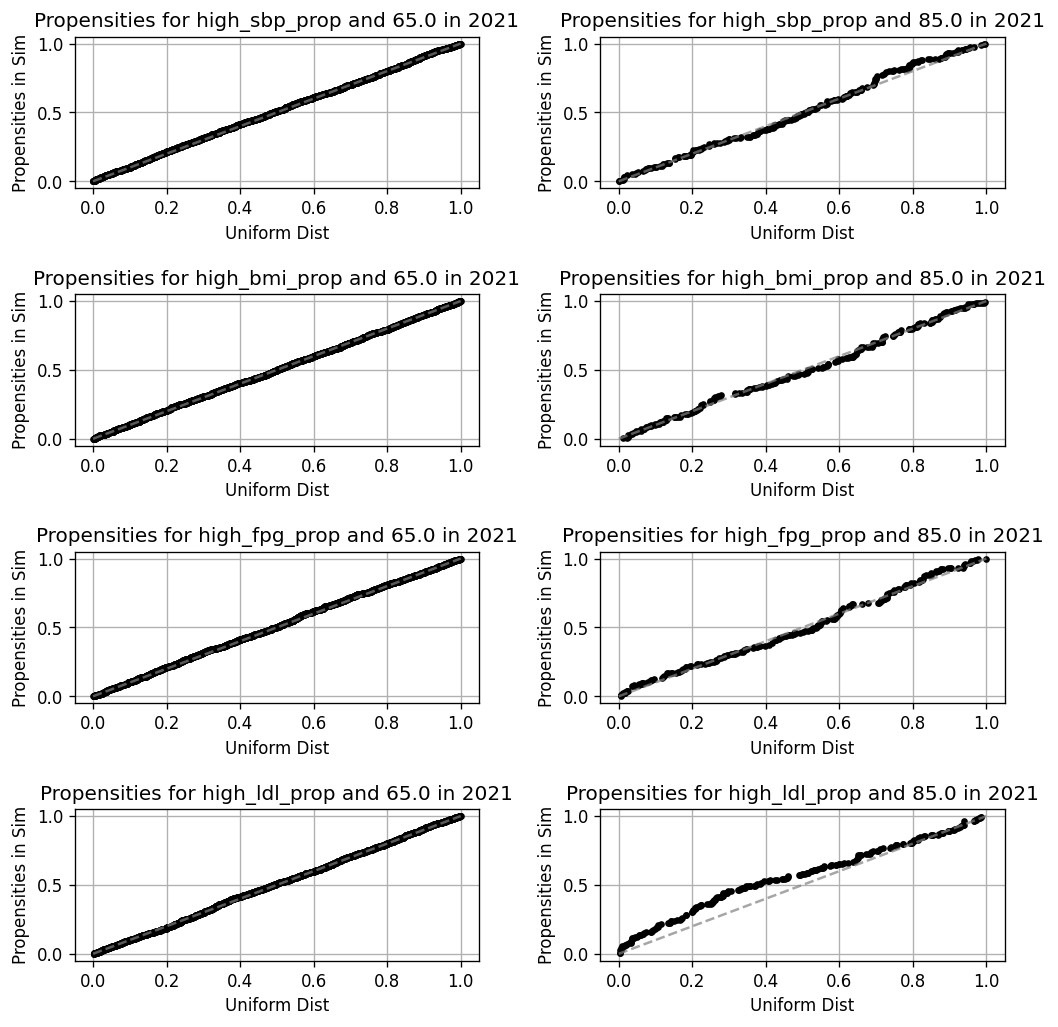

In [76]:
fig, ax = plt.subplots(len(risks), data1_small.age_start.nunique(), dpi=120, figsize=(10,10))
plt.subplots_adjust(wspace=.3, hspace=.7)
for i, risk in enumerate(risks):
    for j, age in enumerate(data1_small.age_start.unique()):
        d = data1_small.query('age_start == @age')
        
        ax[i][j].plot(np.sort(np.random.uniform(size=len(d))),
         d[risk].sort_values(), 'k.')
        ax[i][j].plot([0,1], [0,1], '--', color='grey', alpha=.7)
        ax[i][j].grid()
        ax[i][j].set_xlabel('Uniform Dist')
        ax[i][j].set_ylabel('Propensities in Sim');
        ax[i][j].set_title(f'Propensities for {risk} and {age} in 2021')
        

In [77]:
sim_data = pd.DataFrame()
for step in list(range(0,12*20)):
    print(step, end=', ', flush=True)
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('high_ldl_prop'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('high_sbp_prop'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('high_bmi_prop'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('high_fpg_prop')],
                       axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [78]:
test_data = sim_data
test_data = test_data.loc[(test_data.age > 25) & (test_data.alive == 'alive')]
test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
test_data_small = test_data.loc[(test_data.step==24) & (test_data.sex=='Male')]
test_data_small = test_data_small.loc[(test_data_small.age_start == 85) | (test_data_small.age_start == 65)]
test_data_small

,tracked,entrance_time,location,alive,sex,exit_time,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl,high_sbp,high_bmi,high_fpg,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,step,age_start
17,True,2020-12-04,Washington,alive,Male,NaT,87.791266,not_dead,0.0,0.000000,...,3.790547,123.691047,26.792920,5.393055,0.905945,0.190968,0.538555,0.436118,24,85.0
79,True,2020-12-04,Washington,alive,Male,NaT,68.227310,not_dead,0.0,0.000000,...,3.107551,152.776582,24.150578,4.460897,0.472558,0.895048,0.180425,0.179076,24,65.0
103,True,2020-12-04,Washington,alive,Male,NaT,69.566340,not_dead,0.0,0.000000,...,1.372009,159.246541,28.757589,6.838239,0.109932,0.975411,0.367850,0.697669,24,65.0
159,True,2020-12-04,Washington,alive,Male,NaT,65.537672,not_dead,0.0,0.000000,...,5.500000,138.268528,31.478000,5.525473,0.986903,0.931437,0.689634,0.491468,24,65.0
214,True,2020-12-04,Washington,alive,Male,NaT,68.324640,not_dead,0.0,0.000000,...,2.899898,120.616701,28.432067,6.942273,0.531194,0.288044,0.459662,0.758341,24,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49892,True,2020-12-04,Washington,alive,Male,NaT,66.088834,not_dead,0.0,0.000000,...,3.979945,154.974783,41.843894,5.126627,0.870365,0.921543,0.964961,0.360340,24,65.0
49894,True,2020-12-04,Washington,alive,Male,NaT,69.111801,not_dead,0.0,0.000000,...,2.532310,136.665378,20.297680,4.818877,0.353080,0.787458,0.032725,0.244054,24,65.0
49910,True,2020-12-04,Washington,alive,Male,NaT,67.899017,not_dead,0.0,0.000000,...,1.811824,105.268385,28.355821,4.835615,0.050897,0.057141,0.453884,0.291568,24,65.0
49948,True,2020-12-04,Washington,alive,Male,NaT,87.348891,not_dead,0.0,0.062788,...,2.074448,128.693971,31.774550,4.731642,0.246339,0.369040,0.862387,0.221484,24,85.0


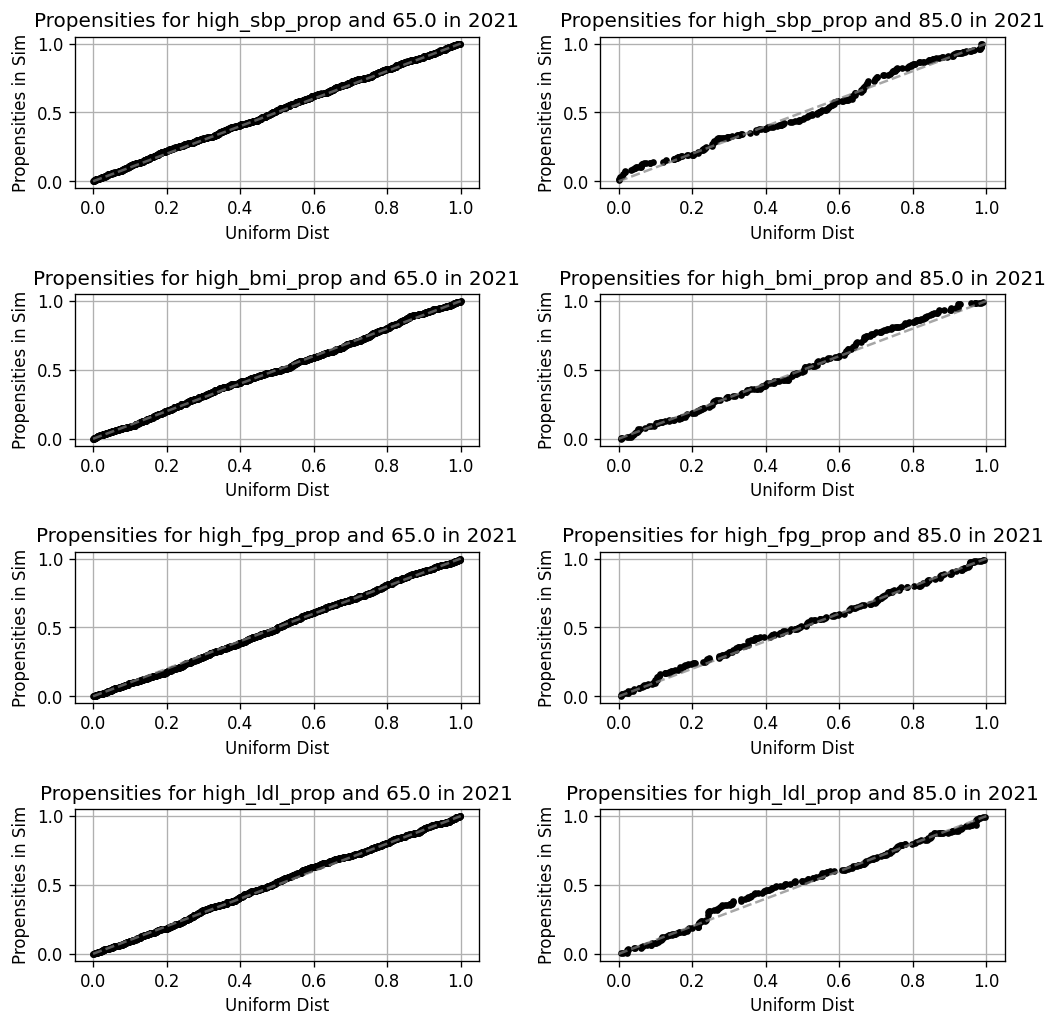

In [79]:
fig, ax = plt.subplots(len(risks), data1_small.age_start.nunique(), dpi=120, figsize=(10,10))
plt.subplots_adjust(wspace=.3, hspace=.7)
for i, risk in enumerate(risks):
    for j, age in enumerate(data1_small.age_start.unique()):
        d = test_data_small.query('age_start == @age')
        
        ax[i][j].plot(np.sort(np.random.uniform(size=len(d))),
         d[risk].sort_values(), 'k.')
        ax[i][j].plot([0,1], [0,1], '--', color='grey', alpha=.7)
        ax[i][j].grid()
        ax[i][j].set_xlabel('Uniform Dist')
        ax[i][j].set_ylabel('Propensities in Sim');
        ax[i][j].set_title(f'Propensities for {risk} and {age} in 2021')
        

In [80]:
# for risk in risks:
#     for age in test_data_small.age_start.unique():
#         ##Need to add a subdata statement here 
#         plt.figure()
#         plt.plot(np.sort(np.random.uniform(size=len(test_data_small))),
#          test_data_small[risk].sort_values(), 'k.')
#         plt.plot([0,1], [0,1], '--', color='grey', alpha=.7)
#         plt.grid()
#         plt.xlabel('Uniform Dist')
#         plt.ylabel('Propensities in Sim');
#         plt.title(f'Propensities for {risk} and {age} for 2023')

In [81]:
test_data_small.high_sbp.mean()

129.87989041442717

## Abie Testing

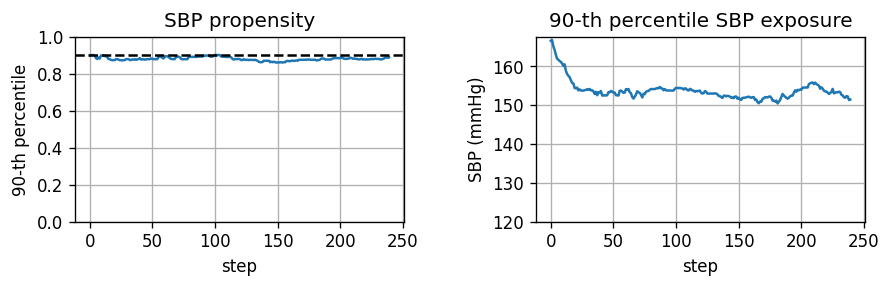

In [82]:
q = 90
age = 80
sex = "Male"
t = sim_data.query('alive == "alive" and sex == @sex and age >= @age and age < @age+5')

plt.figure(figsize=(8.5,2), dpi=120)
plt.subplot(1,2,1)
t.groupby('step').high_sbp_prop.apply(np.percentile, q=q).plot()
plt.axhline(q/100, color='k', linestyle='--')
plt.axis(ymin=0, ymax=1)
plt.ylabel(f'{q}-th percentile')
plt.title('SBP propensity')
plt.grid()

plt.subplot(1,2,2)
t.groupby('step').high_sbp.apply(np.percentile, q=q).plot()
# plt.axhline(120, color='k', linestyle='--')
plt.axis(ymin=120)
plt.ylabel(f'SBP (mmHg)')
plt.title(f'{q}-th percentile SBP exposure')
plt.grid()

plt.subplots_adjust(wspace=.4);

In [83]:
# this seems likely due to treatment

In [84]:
t.filter(like='medication')

,sbp_medication_adherence_propensity,ldlc_medication_adherence_propensity,ldlc_medication_adherence,ldlc_medication,sbp_medication,sbp_medication_adherence
235,0.746436,0.373451,cat3,medium_intensity,no_treatment,cat3
354,0.735701,0.272135,cat2,low_intensity,one_drug_half_dose_efficacy,cat3
561,0.496684,0.118888,cat1,no_treatment,one_drug_half_dose_efficacy,cat3
653,0.383694,0.045650,cat1,low_intensity,no_treatment,cat3
848,0.192005,0.088542,cat1,no_treatment,one_drug_half_dose_efficacy,cat2
...,...,...,...,...,...,...
49481,0.840888,0.426490,cat3,high_with_eze,no_treatment,cat3
49486,0.300304,0.124535,cat1,medium_intensity,one_drug_half_dose_efficacy,cat3
49648,0.041027,0.410441,cat3,low_med_with_eze,one_drug_half_dose_efficacy,cat1
49748,0.294044,0.154299,cat1,high_intensity,no_treatment,cat3


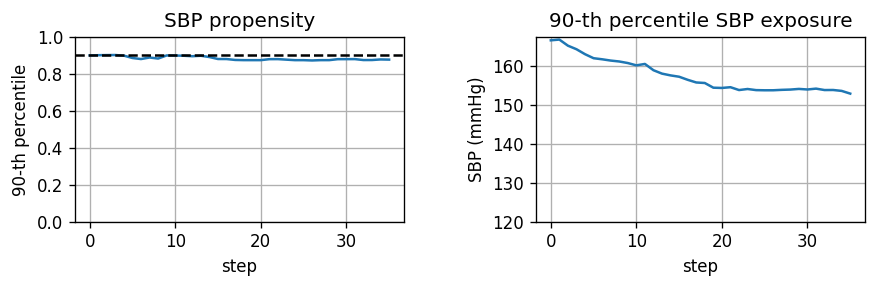

In [85]:
q = 90
age = 80
sex = "Male"
t = sim_data.query('alive == "alive" and sex == @sex and age >= @age and age < @age+5')
t = t.query('step < 36')

plt.figure(figsize=(8.5,2), dpi=120)
plt.subplot(1,2,1)
t.groupby('step').high_sbp_prop.apply(np.percentile, q=q).plot()
plt.axhline(q/100, color='k', linestyle='--')
plt.axis(ymin=0, ymax=1)
plt.ylabel(f'{q}-th percentile')
plt.title('SBP propensity')
plt.grid()

plt.subplot(1,2,2)
t.groupby('step').high_sbp.apply(np.percentile, q=q).plot()
# plt.axhline(120, color='k', linestyle='--')
plt.axis(ymin=120)
plt.ylabel(f'SBP (mmHg)')
plt.title(f'{q}-th percentile SBP exposure')
plt.grid()

plt.subplots_adjust(wspace=.4);

In [86]:
sim_data['any_sbp_meds'] = (sim_data.sbp_medication != 'no_treatment')

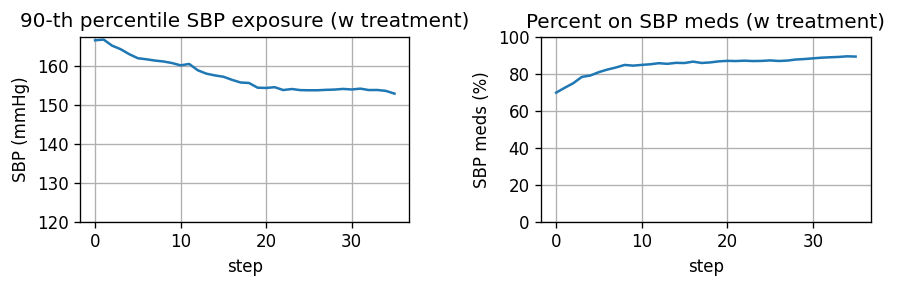

In [89]:
q = 90
age = 80
sex = "Male"
t = sim_data.query('alive == "alive" and sex == @sex and age >= @age and age < @age+5')
t = t.query('step < 36')

plt.figure(figsize=(8.5,2), dpi=120)
plt.subplot(1,2,1)
t.groupby('step').high_sbp.apply(np.percentile, q=q).plot()
# plt.axhline(120, color='k', linestyle='--')
plt.axis(ymin=120)
plt.ylabel(f'SBP (mmHg)')
plt.title(f'{q}-th percentile SBP exposure (w treatment)')
plt.grid()

plt.subplot(1,2,2)
(100*t.groupby('step').any_sbp_meds.apply(np.mean)).plot()
# plt.axhline(120, color='k', linestyle='--')
plt.axis(ymin=0, ymax=100)
plt.ylabel(f'SBP meds (%)')
plt.title(f'Percent on SBP meds (w treatment)')
plt.grid()

plt.subplots_adjust(wspace=.4);

In [90]:
import ipywidgets as ipw
@ipw.interact(q=(0,100,1), age=range(60,100,5), sex=['Male', 'Female'])
def my_plot(q = 90,
            age = 80,
            sex = "Male"):
    t = sim_data.query('alive == "alive" and sex == @sex and age >= @age and age < @age+5')

    plt.figure(figsize=(8.5,2), dpi=120)
    plt.subplot(1,2,1)
    t.groupby('step').high_sbp.apply(np.percentile, q=q).plot()
    # plt.axhline(120, color='k', linestyle='--')
    plt.axis(ymin=120)
    plt.ylabel(f'SBP (mmHg)')
    plt.title(f'{q}-th percentile SBP exposure')
    plt.grid()

    plt.subplot(1,2,2)
    (100*t.groupby('step').any_sbp_meds.apply(np.mean)).plot()
    # plt.axhline(120, color='k', linestyle='--')
    plt.axis(ymin=0, ymax=100)
    plt.ylabel(f'SBP meds (%)')
    plt.title(f'Percent on SBP meds')
    plt.grid()

    plt.subplots_adjust(wspace=.4)

interactive(children=(IntSlider(value=90, description='q'), Dropdown(description='age', index=4, options=(60, …